# Araba Fiyat Tahmini Projesi

**Modeller:** Decision Tree, KNN, Lasso

**Dataset:** Craigslist Car/Trucks Data
https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

### Proje Adımları:
1. Veri Yükleme
2. Keşifsel Veri Analizi (EDA)
3. Veri Temizleme
4. Feature Selection
5. Feature Engineering
6. Train/Test Split
7. Model Eğitimi
8. Hyperparameter Tuning
9. PCA Deneyi
10. Model Karşılaştırması
11. Validation Protokolü
12. Hata Analizi


In [1]:
# Gerekli Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression, f_regression, f_classif

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
print('Kutuphaneler yuklendi')


Kutuphaneler yuklendi


## 1. Veri Yukleme


In [2]:
# Veri Yukleme
df_raw = pd.read_csv(r'C:\Users\Utku\Desktop\veriset_verimadenc\vehicles.csv')
print(f'Ham veri boyutu: {df_raw.shape}')
print(f'Sutunlar: {list(df_raw.columns)}')


Ham veri boyutu: (426880, 26)
Sutunlar: ['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'county', 'state', 'lat', 'long', 'posting_date']


## 2. Keşifsel Veri Analizi (EDA)


In [3]:
# Veri Ozeti
print('='*60)
print('VERI OZETI')
print('='*60)
print(f'Satir sayisi: {len(df_raw):,}')
print(f'Sutun sayisi: {len(df_raw.columns)}')
print(f'\nVeri tipleri:')
print(df_raw.dtypes)
print(f'\nNull deger sayilari:')
print(df_raw.isnull().sum())


VERI OZETI
Satir sayisi: 426,880
Sutun sayisi: 26

Veri tipleri:
id                int64
url              object
region           object
region_url       object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
image_url        object
description      object
county          float64
state            object
lat             float64
long            float64
posting_date     object
dtype: object

Null deger sayilari:
id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400

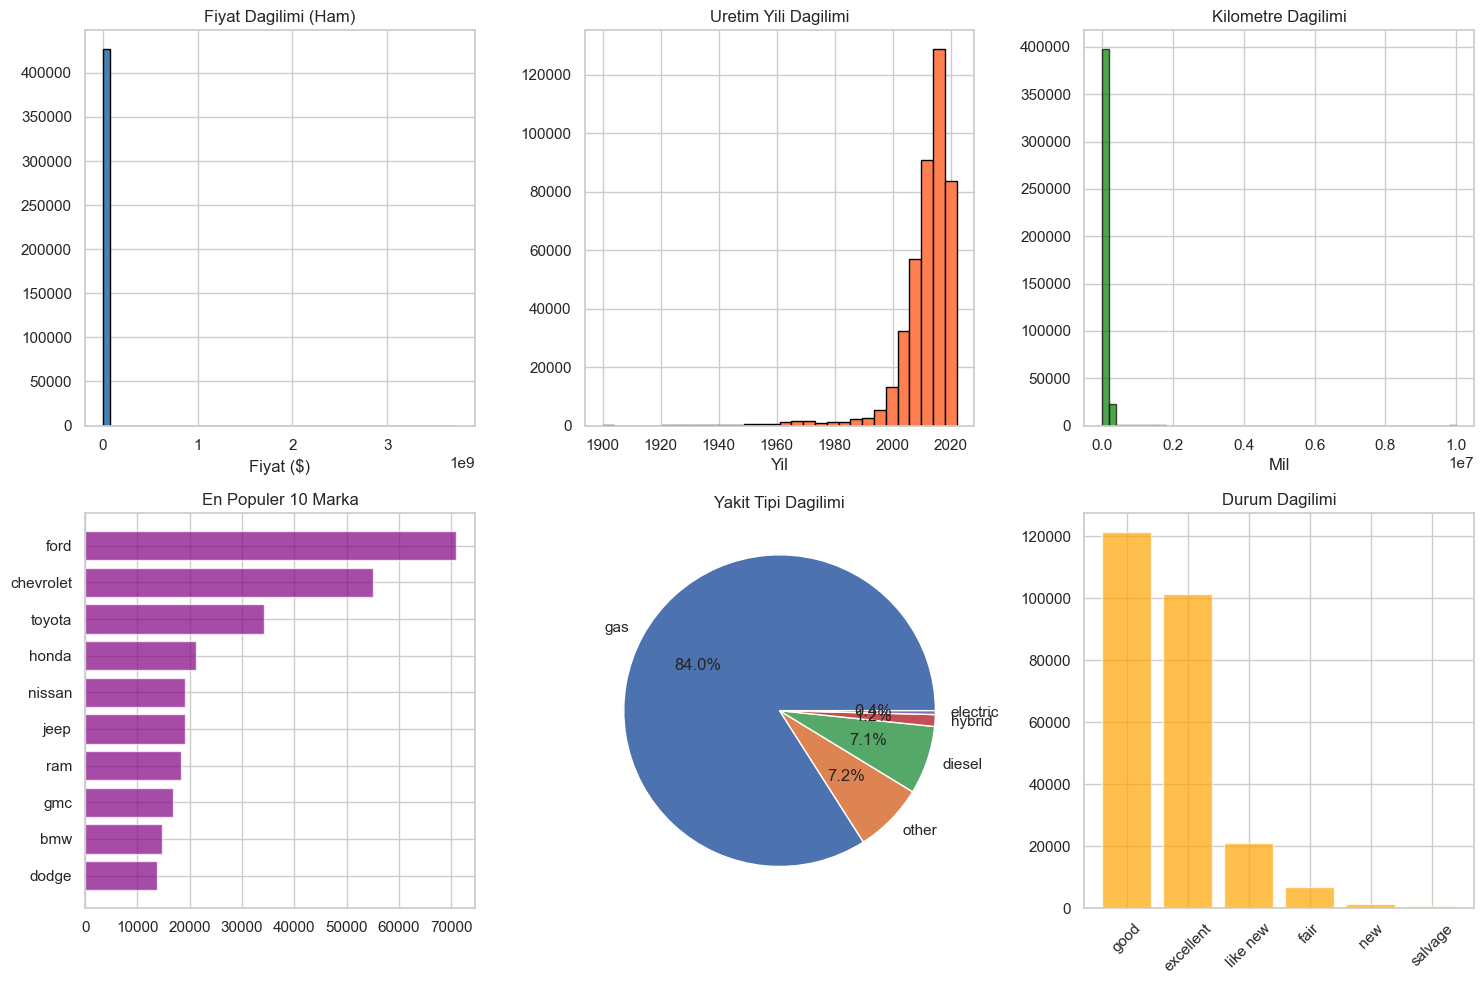

In [4]:
# EDA Grafikleri
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1) Fiyat dagilimi
axes[0,0].hist(df_raw['price'], bins=50, color='steelblue', edgecolor='black')
axes[0,0].set_title('Fiyat Dagilimi (Ham)')
axes[0,0].set_xlabel('Fiyat ($)')

# 2) Yil dagilimi
axes[0,1].hist(df_raw['year'].dropna(), bins=30, color='coral', edgecolor='black')
axes[0,1].set_title('Uretim Yili Dagilimi')
axes[0,1].set_xlabel('Yil')

# 3) Odometer dagilimi
axes[0,2].hist(df_raw['odometer'].dropna(), bins=50, color='green', edgecolor='black', alpha=0.7)
axes[0,2].set_title('Kilometre Dagilimi')
axes[0,2].set_xlabel('Mil')

# 4) Marka dagilimi (Top 10)
top_brands = df_raw['manufacturer'].value_counts().head(10)
axes[1,0].barh(top_brands.index, top_brands.values, color='purple', alpha=0.7)
axes[1,0].set_title('En Populer 10 Marka')
axes[1,0].invert_yaxis()

# 5) Yakit tipi dagilimi
fuel_counts = df_raw['fuel'].value_counts()
axes[1,1].pie(fuel_counts.values, labels=fuel_counts.index, autopct='%1.1f%%')
axes[1,1].set_title('Yakit Tipi Dagilimi')

# 6) Condition dagilimi
cond_counts = df_raw['condition'].value_counts()
axes[1,2].bar(cond_counts.index, cond_counts.values, color='orange', alpha=0.7)
axes[1,2].set_title('Durum Dagilimi')
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 3. Veri Temizleme


In [5]:
# Kullanilacak kolonlari sec (Feature Selection)
keep_cols = ['price', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 
             'odometer', 'title_status', 'transmission', 'drive', 'type']

df = df_raw[keep_cols].copy()

print('='*60)
print('VERI TEMIZLEME')
print('='*60)

# 1) Null degerleri temizle
initial_size = len(df)
df = df.dropna(subset=['price', 'year', 'odometer', 'manufacturer'])
print(f'Null temizleme sonrasi: {len(df):,} ({initial_size - len(df):,} silindi)')

# 2) Fiyat outlierlarini temizle
df = df[(df['price'] >= 500) & (df['price'] <= 500000)]
print(f'Fiyat filtresi sonrasi (500-500K): {len(df):,}')

# 3) Yil filtresi
df = df[df['year'] >= 1980]
print(f'Yil filtresi sonrasi (>=1980): {len(df):,}')

# 4) Odometer filtresi
df = df[df['odometer'] <= 300000]
print(f'Odometer filtresi sonrasi (<=300K): {len(df):,}')


VERI TEMIZLEME
Null temizleme sonrasi: 405,077 (21,803 silindi)
Fiyat filtresi sonrasi (500-500K): 367,087
Yil filtresi sonrasi (>=1980): 360,714
Odometer filtresi sonrasi (<=300K): 359,001


In [6]:
# Kategorik degerlerdeki 'other' temizle
for col in ['cylinders', 'fuel', 'transmission']:
    if col in df.columns:
        df.loc[df[col].str.contains('other', case=False, na=False), col] = np.nan

# Cylinders numeric yap
df['cylinders'] = df['cylinders'].str.split().str[0]
df['cylinders'] = pd.to_numeric(df['cylinders'], errors='coerce')

# Eksik kategorik degerleri mod ile doldur
for col in ['condition', 'fuel', 'title_status', 'transmission', 'drive', 'type']:
    if col in df.columns:
        mode_val = df[col].mode()[0] if len(df[col].mode()) > 0 else 'unknown'
        df[col] = df[col].fillna(mode_val)

# Eksik numeric degerleri median ile doldur
for col in ['cylinders', 'odometer']:
    df[col] = df[col].fillna(df[col].median())

print(f'\nNull deger kontrolu:')
print(df.isnull().sum())



Null deger kontrolu:
price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
dtype: int64


## 3.1 Feature Grafikleri (Veri Temizleme Sonrası)

Her bir feature'ın dağılımını ve fiyat ile ilişkisini görselleştiriyoruz.


NUMERIK FEATURE GRAFIKLERI


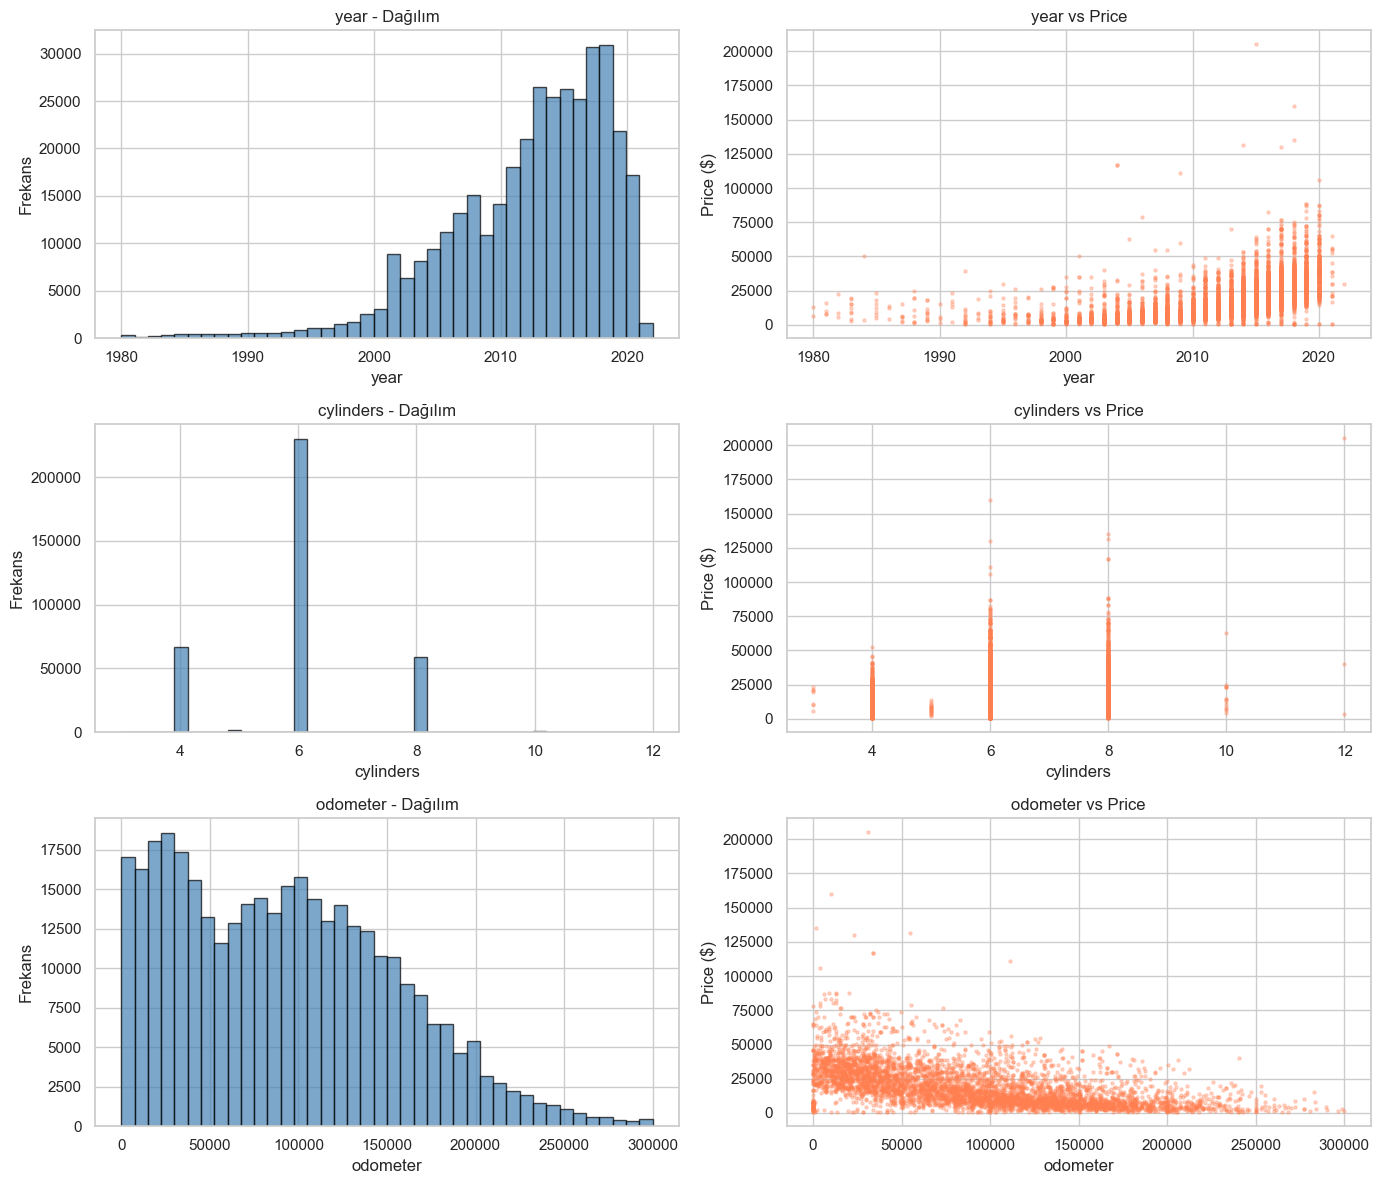

In [7]:
# NUMERIK FEATURE GRAFIKLERI
print('='*60)
print('NUMERIK FEATURE GRAFIKLERI')
print('='*60)

numeric_cols_analysis = ['year', 'cylinders', 'odometer']
fig, axes = plt.subplots(len(numeric_cols_analysis), 2, figsize=(14, 4*len(numeric_cols_analysis)))

for i, col in enumerate(numeric_cols_analysis):
    # Sol: Histogram
    axes[i, 0].hist(df[col].dropna(), bins=40, color='steelblue', edgecolor='black', alpha=0.7)
    axes[i, 0].set_title(f'{col} - Dağılım')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Frekans')
    
    # Sağ: Feature vs Price scatter
    sample = df.sample(min(5000, len(df)), random_state=42)
    axes[i, 1].scatter(sample[col], sample['price'], alpha=0.3, s=5, color='coral')
    axes[i, 1].set_title(f'{col} vs Price')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Price ($)')

plt.tight_layout()
plt.show()


KATEGORIK FEATURE GRAFIKLERI - DAGILIM


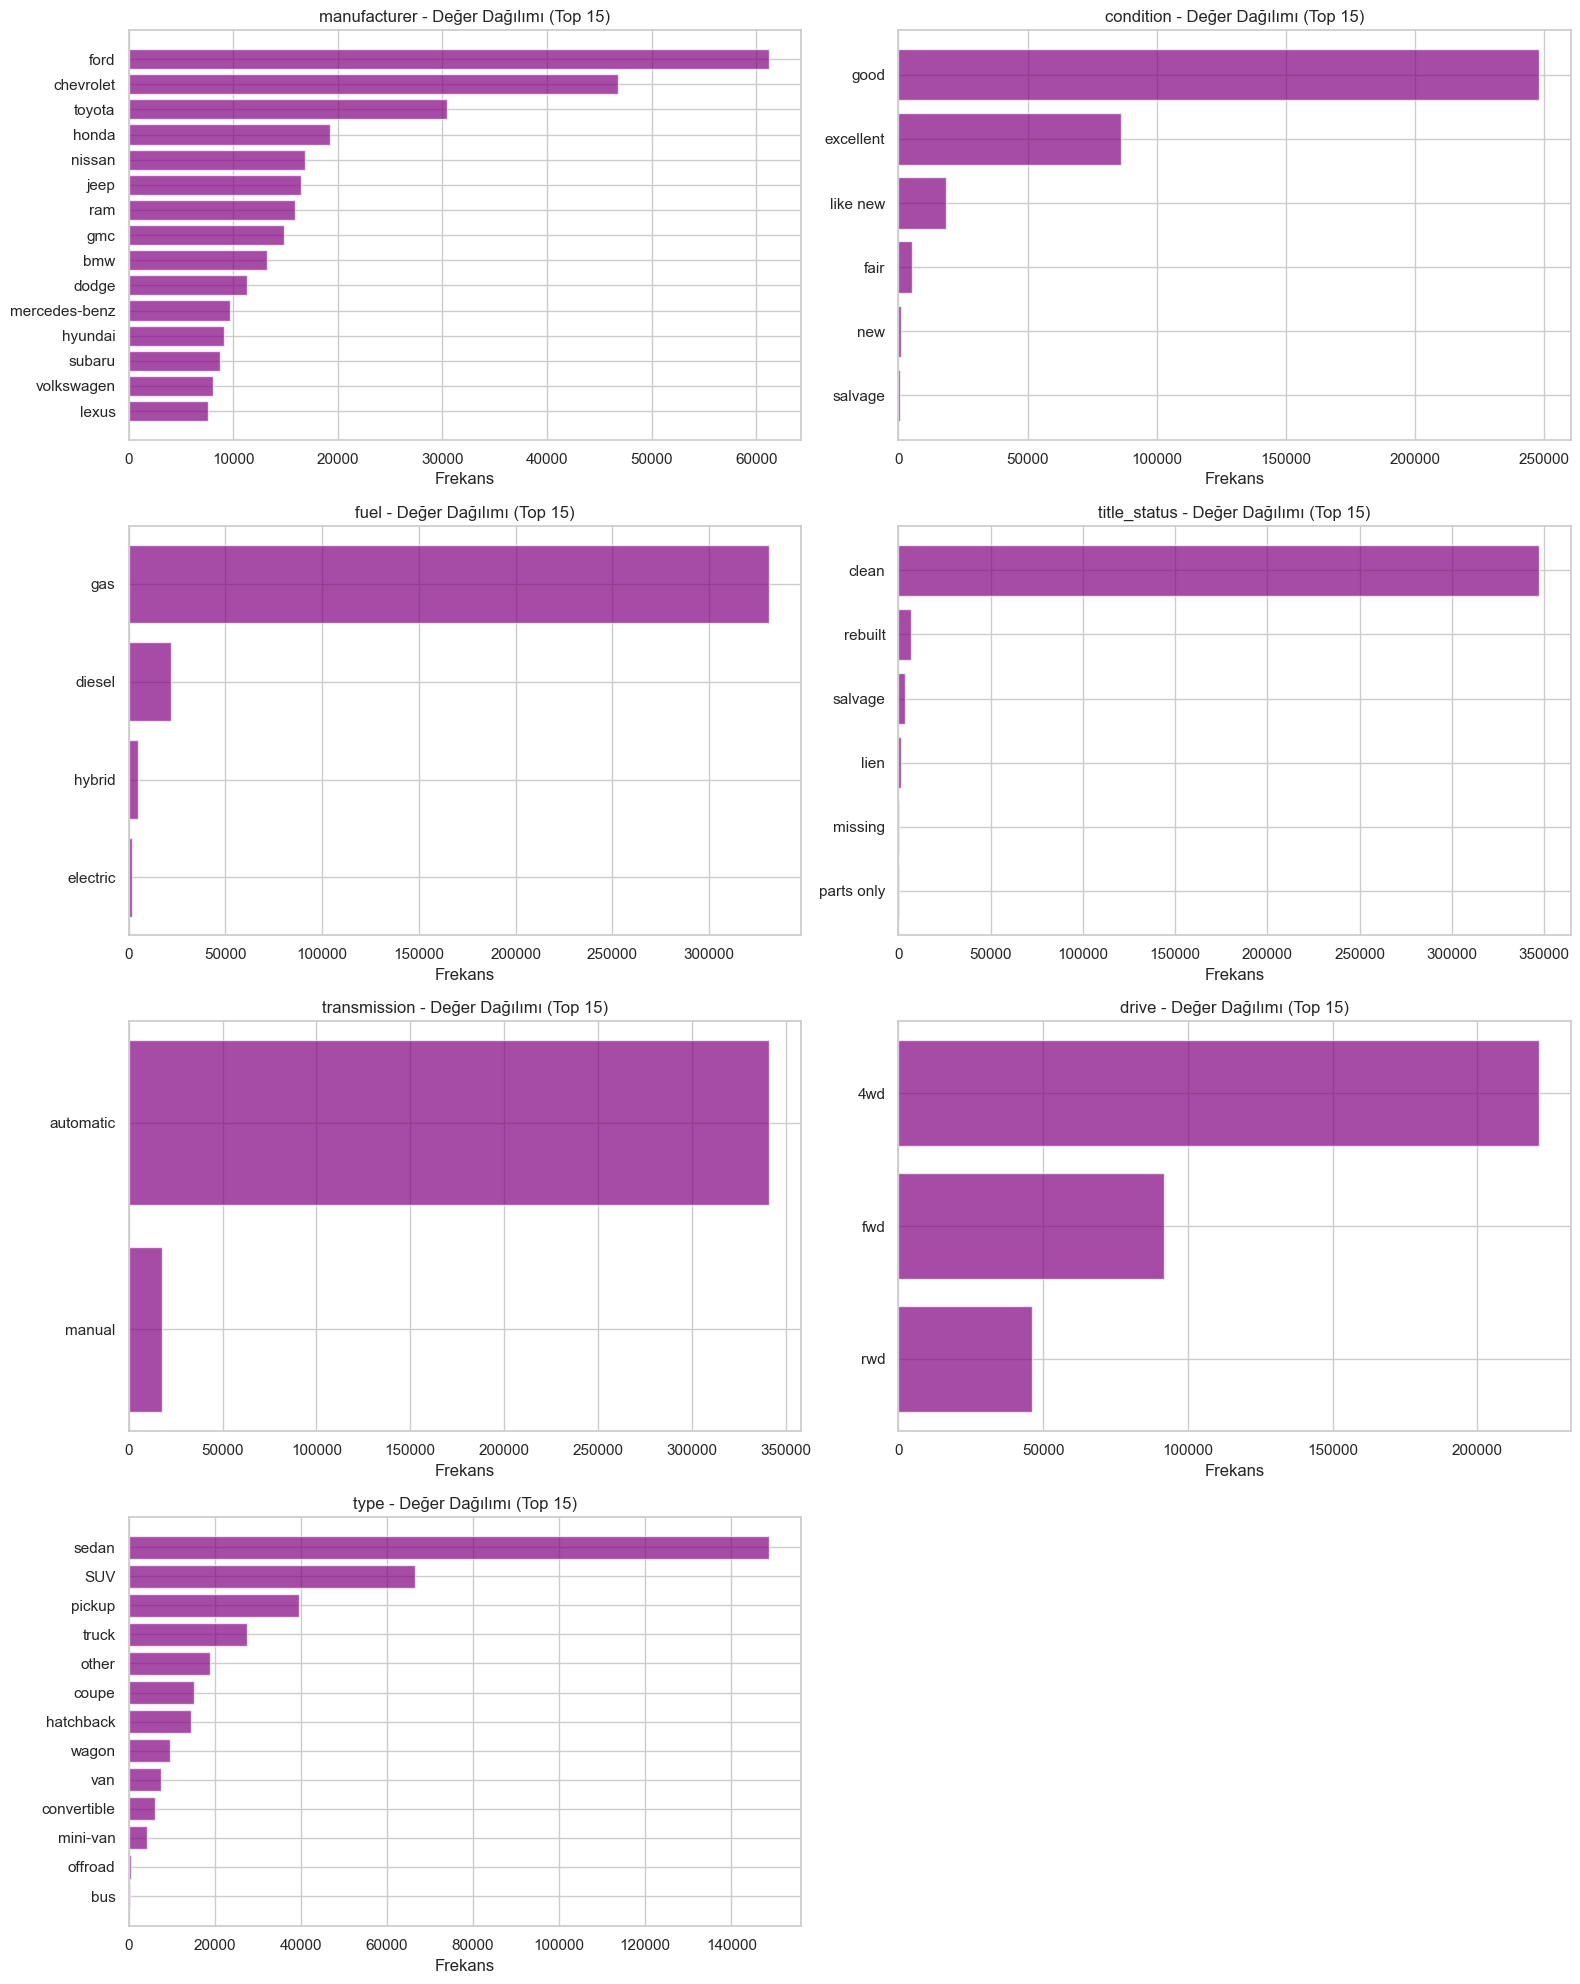

In [8]:
# KATEGORIK FEATURE GRAFIKLERI - SAYIM DAGILIMLARI
print('='*60)
print('KATEGORIK FEATURE GRAFIKLERI - DAGILIM')
print('='*60)

categorical_cols_analysis = ['manufacturer', 'condition', 'fuel', 'title_status', 'transmission', 'drive', 'type']
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_cols_analysis):
    value_counts = df[col].value_counts().head(15)  # Top 15
    axes[i].barh(value_counts.index, value_counts.values, color='purple', alpha=0.7)
    axes[i].set_title(f'{col} - Değer Dağılımı (Top 15)')
    axes[i].set_xlabel('Frekans')
    axes[i].invert_yaxis()

# Son boş subplot'u gizle
if len(categorical_cols_analysis) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()


KATEGORIK FEATURE vs FIYAT (BOXPLOT)


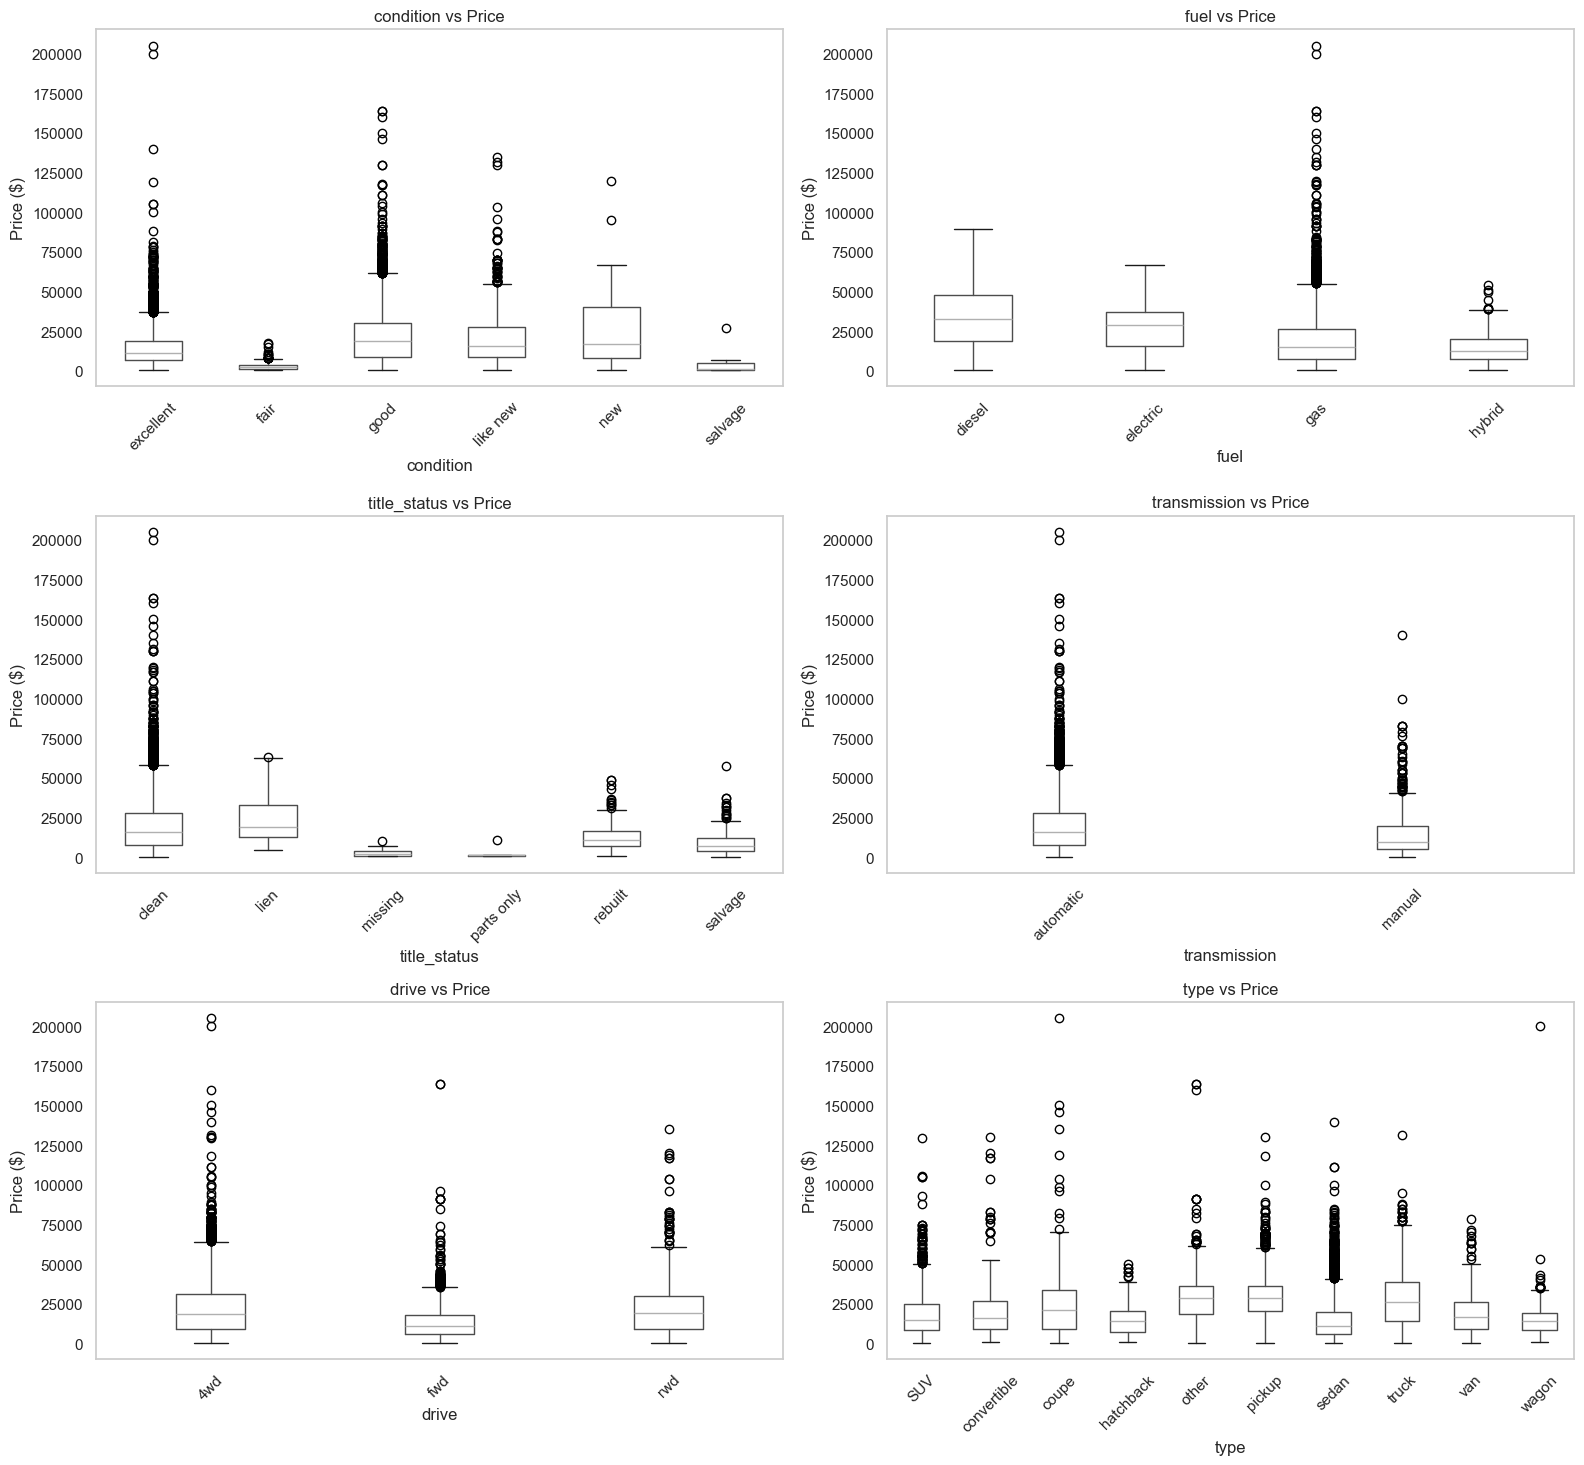

In [9]:
# KATEGORIK FEATURE vs FIYAT - BOXPLOT
print('='*60)
print('KATEGORIK FEATURE vs FIYAT (BOXPLOT)')
print('='*60)

# Daha az kategoriye sahip olanları boxplot için kullanalım
boxplot_cols = ['condition', 'fuel', 'title_status', 'transmission', 'drive', 'type']
fig, axes = plt.subplots(3, 2, figsize=(16, 15))
axes = axes.flatten()

# Örnekleme yapalım (görselleştirme için)
sample_df = df.sample(min(20000, len(df)), random_state=42)

for i, col in enumerate(boxplot_cols):
    # En yaygın 10 kategoriyi al
    top_categories = sample_df[col].value_counts().head(10).index.tolist()
    filtered_df = sample_df[sample_df[col].isin(top_categories)]
    
    # Boxplot
    filtered_df.boxplot(column='price', by=col, ax=axes[i], grid=False)
    axes[i].set_title(f'{col} vs Price')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Price ($)')
    axes[i].tick_params(axis='x', rotation=45)
    plt.suptitle('')  # Ana başlığı kaldır

plt.tight_layout()
plt.show()


MANUFACTURER vs FIYAT (Top 15 Marka)


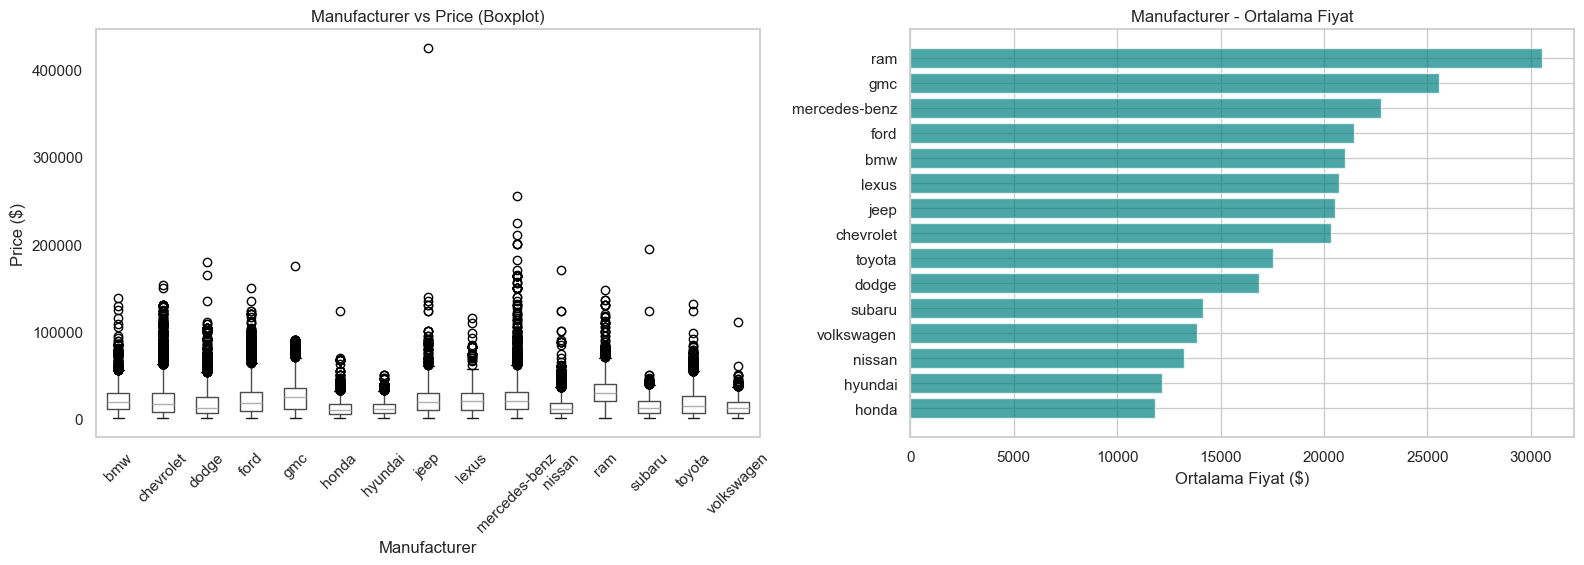

In [10]:
# MANUFACTURER vs FIYAT (Top 15 Marka)
print('='*60)
print('MANUFACTURER vs FIYAT (Top 15 Marka)')
print('='*60)

# Top 15 marka
top_manufacturers = df['manufacturer'].value_counts().head(15).index.tolist()
mfr_df = df[df['manufacturer'].isin(top_manufacturers)]

# Markaları ortalama fiyata göre sırala
mfr_order = mfr_df.groupby('manufacturer')['price'].median().sort_values(ascending=False).index

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sol: Boxplot
mfr_df.boxplot(column='price', by='manufacturer', ax=axes[0], grid=False, positions=range(len(top_manufacturers)))
axes[0].set_title('Manufacturer vs Price (Boxplot)')
axes[0].set_xlabel('Manufacturer')
axes[0].set_ylabel('Price ($)')
axes[0].tick_params(axis='x', rotation=45)
plt.suptitle('')

# Sağ: Ortalama fiyat bar chart
avg_prices = mfr_df.groupby('manufacturer')['price'].mean().sort_values(ascending=True)
axes[1].barh(avg_prices.index, avg_prices.values, color='teal', alpha=0.7)
axes[1].set_title('Manufacturer - Ortalama Fiyat')
axes[1].set_xlabel('Ortalama Fiyat ($)')

plt.tight_layout()
plt.show()


## 3.2 Feature Importance Analizi

### Mutual Information Scores
Mutual Information (MI), iki değişken arasındaki **bağımlılığı** ölçen bilgi-teorik bir metriktir. 
- Non-linear ilişkileri yakalayabilir (korelasyonun aksine)
- Değer ≥ 0 (0 = bağımsız, büyük = güçlü ilişki)

### ANOVA F-test -> bu sadece kategorik sütun
ANOVA F-testi, **kategorik** feature'ların sürekli hedef değişken üzerindeki etkisini ölçer.
- Kategorik değişkenin farklı gruplarının fiyatı anlamlı şekilde farklılaştırıp farklılaştırmadığını test eder
- Yüksek F-score = güçlü ilişki

### f_regression
Numerik feature'lar için univariate(tek değişkenli) lineer regresyon testi.
- Her feature için F-değeri ve p-değeri hesaplar


MUTUAL INFORMATION SCORES

Mutual Information Scores (Yüksek = Güçlü İlişki):
     Feature  MI Score
    odometer  2.604937
        year  0.634303
manufacturer  0.394365
        type  0.304495
   condition  0.158290
   cylinders  0.141324
       drive  0.117647
        fuel  0.083586
title_status  0.026684
transmission  0.022551


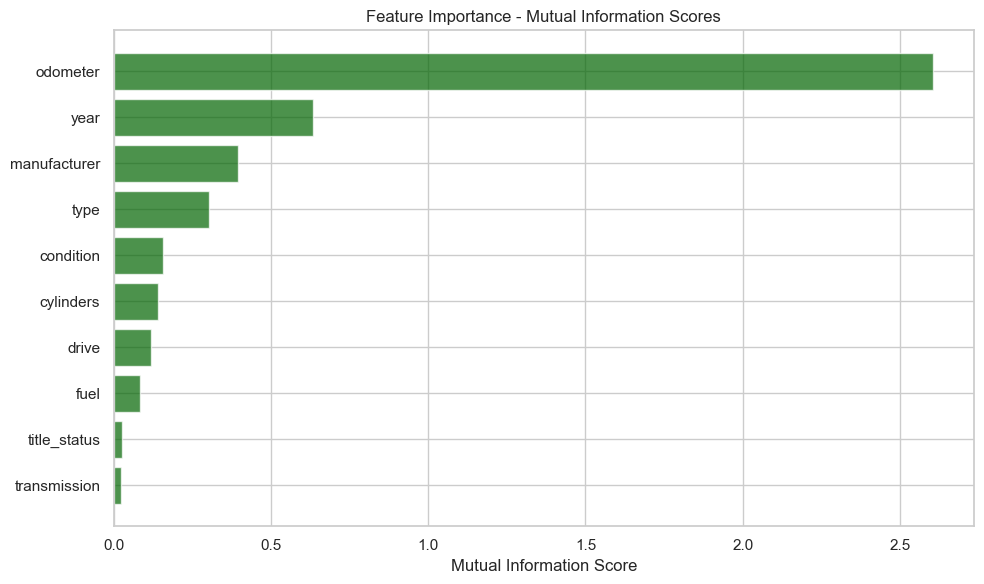

In [11]:
# MUTUAL INFORMATION SCORES
print('='*60)
print('MUTUAL INFORMATION SCORES')
print('='*60)

# Analiz için veri hazırlığı
analysis_df = df.copy()

# Kategorik kolonları encode edelim (MI hesabı için)
le_dict = {}
categorical_for_mi = ['manufacturer', 'condition', 'fuel', 'title_status', 'transmission', 'drive', 'type']

for col in categorical_for_mi:
    le = LabelEncoder()
    analysis_df[col + '_encoded'] = le.fit_transform(analysis_df[col].astype(str))
    le_dict[col] = le

# Tüm feature'ları birleştir
all_features_for_mi = ['year', 'cylinders', 'odometer'] + [col + '_encoded' for col in categorical_for_mi]
X_mi = analysis_df[all_features_for_mi].values
y_mi = analysis_df['price'].values

# Mutual Information hesapla
mi_scores = mutual_info_regression(X_mi, y_mi, random_state=42)

# Sonuçları DataFrame'e çevir
feature_names_mi = ['year', 'cylinders', 'odometer'] + categorical_for_mi
mi_df = pd.DataFrame({
    'Feature': feature_names_mi,
    'MI Score': mi_scores
}).sort_values('MI Score', ascending=False)

print('\nMutual Information Scores (Yüksek = Güçlü İlişki):')
print(mi_df.to_string(index=False))

# MI Scores görselleştirme
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['MI Score'], color='darkgreen', alpha=0.7)
plt.xlabel('Mutual Information Score')
plt.title('Feature Importance - Mutual Information Scores')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


ANOVA F-TEST (Kategorik Feature'lar için)

ANOVA F-Test Sonuçları (Kategorik Features):
     Feature  F-Statistic  P-Value Significant (p<0.05)
       drive 12180.839394      0.0                  Yes
        fuel  9848.196758      0.0                  Yes
        type  4900.677464      0.0                  Yes
   condition  3396.632668      0.0                  Yes
transmission  2052.657147      0.0                  Yes
manufacturer  1289.741730      0.0                  Yes
title_status   662.010356      0.0                  Yes


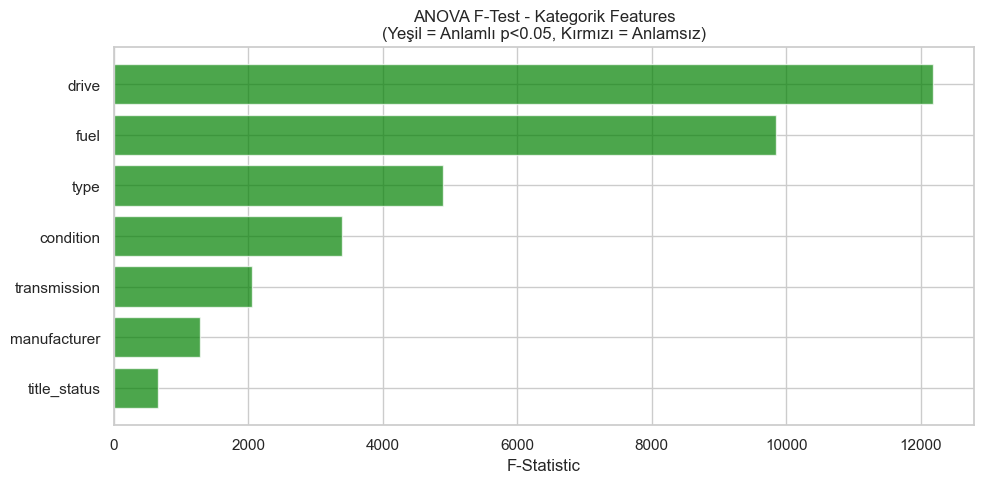

In [12]:
# ANOVA F-TEST (Kategorik Features için)
print('='*60)
print('ANOVA F-TEST (Kategorik Feature\'lar için)')
print('='*60)

from scipy import stats

anova_results = []
target = analysis_df['price']

for col in categorical_for_mi:
    groups = [group['price'].values for name, group in analysis_df.groupby(col)]
    # ANOVA F-test
    f_stat, p_value = stats.f_oneway(*groups)
    anova_results.append({
        'Feature': col,
        'F-Statistic': f_stat,
        'P-Value': p_value,
        'Significant (p<0.05)': 'Yes' if p_value < 0.05 else 'No'
    })

anova_df = pd.DataFrame(anova_results).sort_values('F-Statistic', ascending=False)
print('\nANOVA F-Test Sonuçları (Kategorik Features):')
print(anova_df.to_string(index=False))

# F-Statistic görselleştirme
plt.figure(figsize=(10, 5))
colors = ['green' if p < 0.05 else 'red' for p in anova_df['P-Value']]
plt.barh(anova_df['Feature'], anova_df['F-Statistic'], color=colors, alpha=0.7)
plt.xlabel('F-Statistic')
plt.title('ANOVA F-Test - Kategorik Features\n(Yeşil = Anlamlı p<0.05, Kırmızı = Anlamsız)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


F-REGRESSION (Numerik Feature'lar için)

F-Regression Sonuçları (Numerik Features):
  Feature       F-Score  P-Value Significant (p<0.05)
     year 154167.717747      0.0                  Yes
 odometer 150991.046608      0.0                  Yes
cylinders  27251.783805      0.0                  Yes


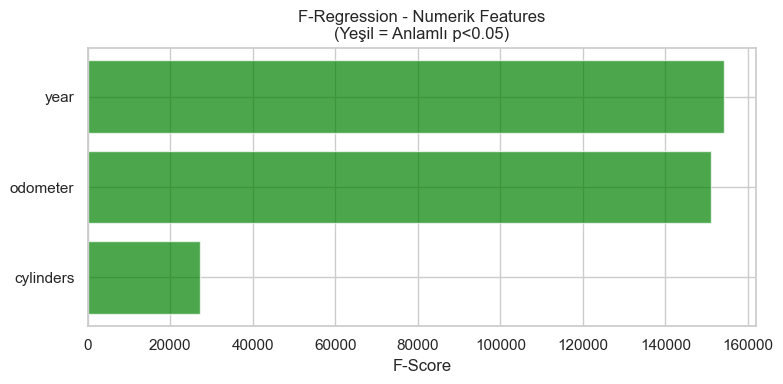

In [13]:
# F-REGRESSION (Numerik Features için)
print('='*60)
print('F-REGRESSION (Numerik Feature\'lar için)')
print('='*60)

# Numerik feature'lar
numeric_features_analysis = ['year', 'cylinders', 'odometer']
X_numeric = analysis_df[numeric_features_analysis].values
y_target = analysis_df['price'].values

# F-regression hesapla
f_scores, p_values = f_regression(X_numeric, y_target)

freg_df = pd.DataFrame({
    'Feature': numeric_features_analysis,
    'F-Score': f_scores,
    'P-Value': p_values,
    'Significant (p<0.05)': ['Yes' if p < 0.05 else 'No' for p in p_values]
}).sort_values('F-Score', ascending=False)

print('\nF-Regression Sonuçları (Numerik Features):')
print(freg_df.to_string(index=False))

# F-Score görselleştirme
plt.figure(figsize=(8, 4))
colors = ['green' if p < 0.05 else 'red' for p in freg_df['P-Value']]
plt.barh(freg_df['Feature'], freg_df['F-Score'], color=colors, alpha=0.7)
plt.xlabel('F-Score')
plt.title('F-Regression - Numerik Features\n(Yeşil = Anlamlı p<0.05)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


FEATURE IMPORTANCE KARŞILAŞTIRMA ÖZETİ

--- NUMERIK FEATURES ---
Feature      Korelasyon   MI Score     F-Score        
--------------------------------------------------
year         0.5481       0.6343       154167.7       
cylinders    0.2656       0.1413       27251.8        
odometer     -0.5441      2.6049       150991.0       

--- KATEGORIK FEATURES ---
Feature         MI Score     ANOVA F-Stat   
---------------------------------------------
manufacturer    0.3944       1289.7         
condition       0.1583       3396.6         
fuel            0.0836       9848.2         
title_status    0.0267       662.0          
transmission    0.0226       2052.7         
drive           0.1176       12180.8        
type            0.3045       4900.7         

--- GENEL FEATURE RANKING (MI Score Bazlı) ---
     Feature  MI Score
    odometer  2.604937
        year  0.634303
manufacturer  0.394365
        type  0.304495
   condition  0.158290
   cylinders  0.141324
       drive  0.11764

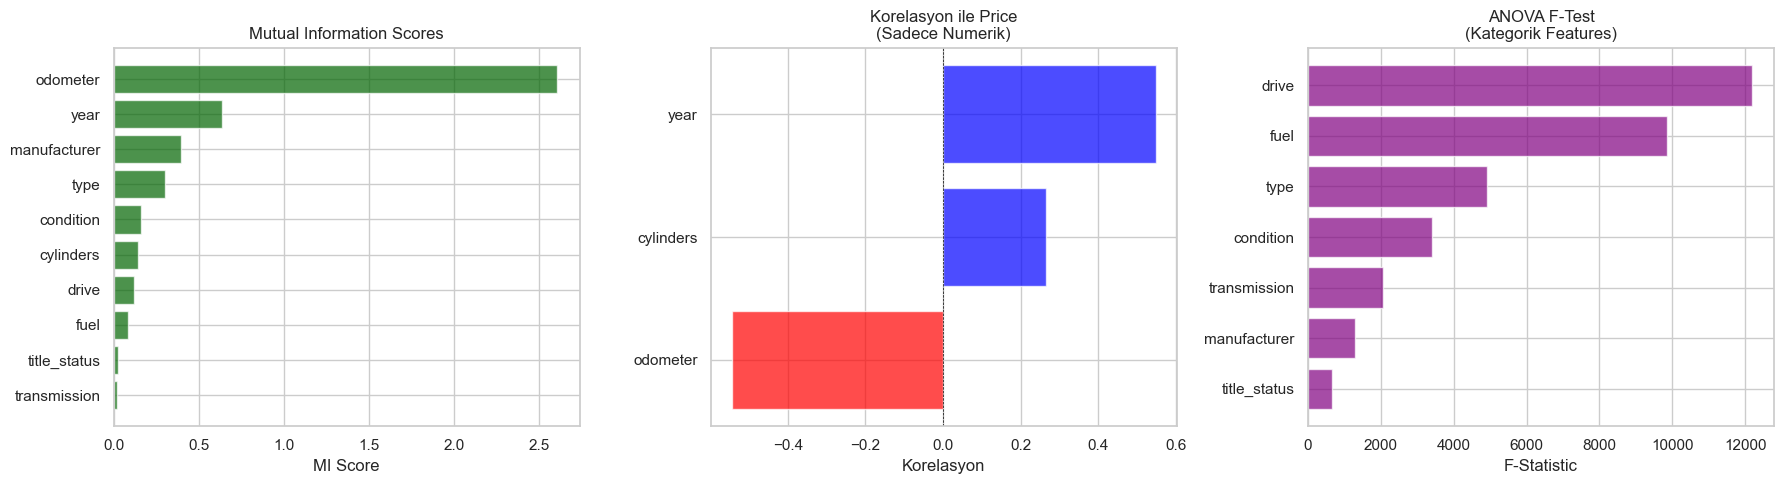


📊 YORUM:
- Yüksek MI Score: Feature, fiyatı tahmin etmede bilgi sağlıyor (linear/non-linear)
- Yüksek Korelasyon: Feature ile fiyat arasında güçlü lineer ilişki var
- Yüksek F-Statistic: Kategorik gruplar arasında anlamlı fiyat farkları var


In [14]:
# FEATURE IMPORTANCE KARSILASTIRMA OZETI
print('='*60)
print('FEATURE IMPORTANCE KARŞILAŞTIRMA ÖZETİ')
print('='*60)

# Korelasyon (sadece numerik için)
corr_with_price = analysis_df[['year', 'cylinders', 'odometer', 'price']].corr()['price'].drop('price')

# Özet tablo
print('\n--- NUMERIK FEATURES ---')
print(f'{"Feature":<12} {"Korelasyon":<12} {"MI Score":<12} {"F-Score":<15}')
print('-'*50)
for feat in ['year', 'cylinders', 'odometer']:
    corr_val = corr_with_price[feat]
    mi_val = mi_df[mi_df['Feature'] == feat]['MI Score'].values[0]
    f_val = freg_df[freg_df['Feature'] == feat]['F-Score'].values[0]
    print(f'{feat:<12} {corr_val:<12.4f} {mi_val:<12.4f} {f_val:<15.1f}')

print('\n--- KATEGORIK FEATURES ---')
print(f'{"Feature":<15} {"MI Score":<12} {"ANOVA F-Stat":<15}')
print('-'*45)
for feat in categorical_for_mi:
    mi_val = mi_df[mi_df['Feature'] == feat]['MI Score'].values[0]
    f_val = anova_df[anova_df['Feature'] == feat]['F-Statistic'].values[0]
    print(f'{feat:<15} {mi_val:<12.4f} {f_val:<15.1f}')

# Genel Feature Ranking (MI bazlı)
print('\n--- GENEL FEATURE RANKING (MI Score Bazlı) ---')
print(mi_df.to_string(index=False))

# Karşılaştırma grafiği
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) MI Scores
mi_sorted = mi_df.sort_values('MI Score', ascending=True)
axes[0].barh(mi_sorted['Feature'], mi_sorted['MI Score'], color='darkgreen', alpha=0.7)
axes[0].set_xlabel('MI Score')
axes[0].set_title('Mutual Information Scores')

# 2) Korelasyon (Numerik)
corr_sorted = corr_with_price.sort_values()
colors_corr = ['red' if v < 0 else 'blue' for v in corr_sorted]
axes[1].barh(corr_sorted.index, corr_sorted.values, color=colors_corr, alpha=0.7)
axes[1].axvline(0, color='black', linestyle='--', linewidth=0.5)
axes[1].set_xlabel('Korelasyon')
axes[1].set_title('Korelasyon ile Price\n(Sadece Numerik)')

# 3) ANOVA F-Stat (Kategorik)
anova_sorted = anova_df.sort_values('F-Statistic', ascending=True)
axes[2].barh(anova_sorted['Feature'], anova_sorted['F-Statistic'], color='purple', alpha=0.7)
axes[2].set_xlabel('F-Statistic')
axes[2].set_title('ANOVA F-Test\n(Kategorik Features)')

plt.tight_layout()
plt.show()

print('\n📊 YORUM:')
print('- Yüksek MI Score: Feature, fiyatı tahmin etmede bilgi sağlıyor (linear/non-linear)')
print('- Yüksek Korelasyon: Feature ile fiyat arasında güçlü lineer ilişki var')
print('- Yüksek F-Statistic: Kategorik gruplar arasında anlamlı fiyat farkları var')


## 4. Feature Selection (Ozellik Secimi)

**Cikarilan kolonlar:**
- `lat`, `long` - Price ile dusuk korelasyon
- `region` - 404 unique deger (cok fazla)
- `model` - 20,000+ unique deger (cok fazla)
- `VIN`, `url`, `image_url` vb. - Model icin gereksiz


KORELASYON ANALIZI


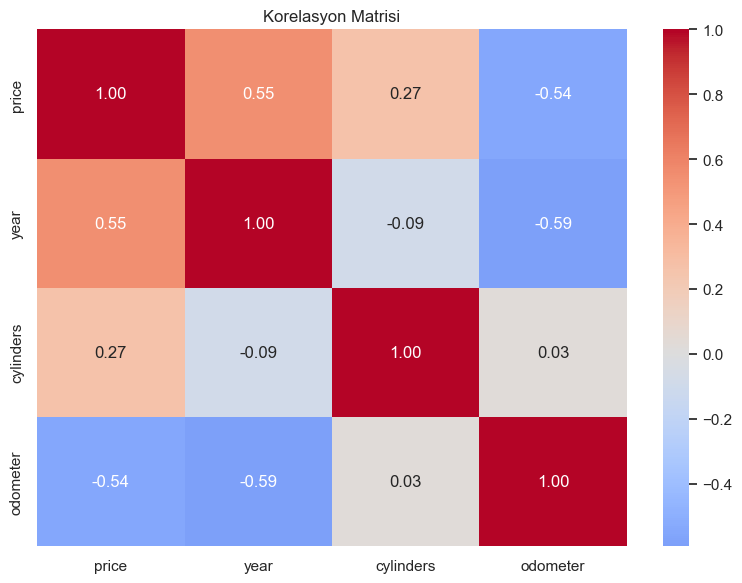


Price ile korelasyonlar:
price        1.000000
year         0.548110
cylinders    0.265621
odometer    -0.544120
Name: price, dtype: float64


In [15]:
# Korelasyon Analizi
print('='*60)
print('KORELASYON ANALIZI')
print('='*60)

numeric_cols = ['price', 'year', 'cylinders', 'odometer']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Korelasyon Matrisi')
plt.tight_layout()
plt.show()

print('\nPrice ile korelasyonlar:')
print(corr_matrix['price'].sort_values(ascending=False))


## 5. Feature Engineering


In [16]:
# Feature Engineering
print('='*60)
print('FEATURE ENGINEERING')
print('='*60)

# 1) Arac yasi
df['car_age'] = 2025 - df['year']
print('car_age eklendi')

# 2) Yillik km
df['mil_per_year'] = df['odometer'] / df['car_age'].replace(0, 1)
print('mil_per_year eklendi')

# 3) Condition duzeltme (km bazli)
def correct_condition(row):
    odometer = row['odometer']
    if odometer <= 10000: return 'new'
    elif odometer <= 50000: return 'like new'
    elif odometer <= 100000: return 'excellent'
    elif odometer <= 150000: return 'good'
    else: return 'fair'

df['condition'] = df.apply(correct_condition, axis=1)
print('condition km bazli duzeltildi')

# 4) Year kolonunu cikar (car_age var)
df = df.drop(columns=['year'])
print('year kolonu cikarildi')

print(f'\nFinal kolonlar: {list(df.columns)}')


FEATURE ENGINEERING
car_age eklendi
mil_per_year eklendi
condition km bazli duzeltildi
year kolonu cikarildi

Final kolonlar: ['price', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 'car_age', 'mil_per_year']


## 6. Train/Test Split


In [17]:
# Feature ve Target ayirma
X = df.drop('price', axis=1)
y = np.log1p(df['price'])  # Log transform

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('='*60)
print('TRAIN/TEST SPLIT')
print('='*60)
print(f'X_train: {X_train.shape}')
print(f'X_test:  {X_test.shape}')
print(f'Ortalama fiyat ($): Train=${np.expm1(y_train.mean()):,.0f}, Test=${np.expm1(y_test.mean()):,.0f}')


TRAIN/TEST SPLIT
X_train: (287200, 11)
X_test:  (71801, 11)
Ortalama fiyat ($): Train=$13,957, Test=$13,931


In [18]:
# Feature gruplari ve Preprocessor tanimlari
numeric_features = ['cylinders', 'odometer', 'car_age', 'mil_per_year']

ordinal_features = ['condition', 'title_status']
ordinal_categories = [
    ['salvage', 'fair', 'good', 'excellent', 'like new', 'new'],
    ['parts only', 'missing', 'salvage', 'lien', 'rebuilt', 'clean']
]

nominal_features = ['manufacturer', 'fuel', 'transmission', 'drive', 'type']

# Label Encoding Preprocessor (Decision Tree, KNN icin)
preprocessor_label = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('ord', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1), ordinal_features),
    ('nom', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), nominal_features)
], remainder='drop')

# OneHot Encoding Preprocessor (Lasso icin)
preprocessor_onehot = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('ord', OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', unknown_value=-1), ordinal_features),
    ('nom', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_features)
], remainder='drop')

print('Preprocessor tanimlandi')


Preprocessor tanimlandi


## 7. Model Egitimi


In [19]:
# Sonuclari saklamak icin
results = {}

# Dumb Baseline
print('='*60)
print('DUMB BASELINE (MEAN PREDICTOR)')
print('='*60)
y_pred_baseline = np.full_like(y_test, y_train.mean())
rmse_baseline = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_baseline)))
r2_baseline = r2_score(y_test, y_pred_baseline)
results['Baseline'] = {'RMSE': rmse_baseline, 'R2': r2_baseline}
print(f'Test R2: {r2_baseline:.4f} | RMSE: ${rmse_baseline:,.0f}')


DUMB BASELINE (MEAN PREDICTOR)
Test R2: -0.0000 | RMSE: $15,852


In [20]:
# Decision Tree (Label Encoding)
print('='*60)
print('DECISION TREE')
print('='*60)
pipeline_dt = Pipeline([('preprocessor', preprocessor_label), ('model', DecisionTreeRegressor(max_depth=15, min_samples_split=20, min_samples_leaf=10, random_state=42))])
pipeline_dt.fit(X_train, y_train)
y_pred_dt = pipeline_dt.predict(X_test)
r2_dt = r2_score(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_dt)))
results['Decision Tree'] = {'RMSE': rmse_dt, 'R2': r2_dt, 'pipeline': pipeline_dt}
print(f'Test R2: {r2_dt:.4f} | RMSE: ${rmse_dt:,.0f}')


DECISION TREE
Test R2: 0.7058 | RMSE: $7,787


In [21]:
# KNN (Label Encoding)
print('='*60)
print('KNN')
print('='*60)
pipeline_knn = Pipeline([('preprocessor', preprocessor_label), ('model', KNeighborsRegressor(n_neighbors=5, weights='distance', p=2))])
pipeline_knn.fit(X_train, y_train)
y_pred_knn = pipeline_knn.predict(X_test)
r2_knn = r2_score(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_knn)))
results['KNN'] = {'RMSE': rmse_knn, 'R2': r2_knn, 'pipeline': pipeline_knn}
print(f'Test R2: {r2_knn:.4f} | RMSE: ${rmse_knn:,.0f}')


KNN
Test R2: 0.7935 | RMSE: $5,495


In [22]:
# Lasso (OneHot Encoding - linear model)
print('='*60)
print('LASSO')
print('='*60)
pipeline_lasso = Pipeline([('preprocessor', preprocessor_onehot), ('model', Lasso(alpha=0.001, max_iter=10000, random_state=42))])
pipeline_lasso.fit(X_train, y_train)
y_pred_lasso = pipeline_lasso.predict(X_test)
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_lasso)))
results['Lasso'] = {'RMSE': rmse_lasso, 'R2': r2_lasso, 'pipeline': pipeline_lasso}
print(f'Test R2: {r2_lasso:.4f} | RMSE: ${rmse_lasso:,.0f}')


LASSO
Test R2: 0.6326 | RMSE: $9,134


## 8. Hyperparameter Tuning

Modelin parametrelerini en iyi sonucu verecek sekilde otomatik bulma islemi.


In [23]:
# Decision Tree Tuning
print('='*60)
print('DECISION TREE - HYPERPARAMETER TUNING')
print('='*60)
param_grid_dt = {'model__max_depth': [10, 12, 15, 18], 'model__min_samples_split': [10, 20, 30], 'model__min_samples_leaf': [5, 10, 15]}
search_dt = RandomizedSearchCV(pipeline_dt, param_grid_dt, n_iter=12, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
search_dt.fit(X_train, y_train)
print(f'En iyi parametreler: {search_dt.best_params_}')
y_pred = search_dt.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
results['Decision Tree (Tuned)'] = {'RMSE': rmse, 'R2': r2, 'pipeline': search_dt.best_estimator_}
print(f'Tuned Test R2: {r2:.4f} | RMSE: ${rmse:,.0f}')


DECISION TREE - HYPERPARAMETER TUNING
En iyi parametreler: {'model__min_samples_split': 10, 'model__min_samples_leaf': 10, 'model__max_depth': 18}
Tuned Test R2: 0.7196 | RMSE: $7,496


In [24]:
# KNN Tuning
print('='*60)
print('KNN - HYPERPARAMETER TUNING')
print('='*60)
param_grid_knn = {'model__n_neighbors': [3, 5, 7, 10, 15], 'model__weights': ['uniform', 'distance'], 'model__p': [1, 2]}
search_knn = RandomizedSearchCV(pipeline_knn, param_grid_knn, n_iter=12, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
search_knn.fit(X_train, y_train)
print(f'En iyi parametreler: {search_knn.best_params_}')
y_pred = search_knn.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
results['KNN (Tuned)'] = {'RMSE': rmse, 'R2': r2, 'pipeline': search_knn.best_estimator_}
print(f'Tuned Test R2: {r2:.4f} | RMSE: ${rmse:,.0f}')


KNN - HYPERPARAMETER TUNING
En iyi parametreler: {'model__weights': 'distance', 'model__p': 1, 'model__n_neighbors': 15}
Tuned Test R2: 0.8112 | RMSE: $5,312


In [25]:
# Lasso Tuning
print('='*60)
print('LASSO - HYPERPARAMETER TUNING')
print('='*60)
param_grid_lasso = {'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}
search_lasso = RandomizedSearchCV(pipeline_lasso, param_grid_lasso, n_iter=5, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
search_lasso.fit(X_train, y_train)
print(f'En iyi parametreler: {search_lasso.best_params_}')
y_pred = search_lasso.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
results['Lasso (Tuned)'] = {'RMSE': rmse, 'R2': r2, 'pipeline': search_lasso.best_estimator_}
print(f'Tuned Test R2: {r2:.4f} | RMSE: ${rmse:,.0f}')


LASSO - HYPERPARAMETER TUNING
En iyi parametreler: {'model__alpha': 0.0001}
Tuned Test R2: 0.6385 | RMSE: $8,928


## 9. PCA Deneyi

Boyut indirgeme teknigi. Cok sayida ozelligi daha az sayida bilesene indirger.


In [26]:
# PCA Deneyi - Tum Modeller
print('='*60)
print('PCA DENEYI (Tum Modeller)')
print('='*60)

n_comp = 10
pca_results = {}

# Decision Tree + PCA
pipe_dt_pca = Pipeline([('preprocessor', preprocessor_label), ('pca', PCA(n_components=n_comp)), ('model', DecisionTreeRegressor(max_depth=15, min_samples_split=20, min_samples_leaf=10, random_state=42))])
pipe_dt_pca.fit(X_train, y_train)
y_pred = pipe_dt_pca.predict(X_test)
pca_results['Decision Tree'] = r2_score(y_test, y_pred)

# KNN + PCA
pipe_knn_pca = Pipeline([('preprocessor', preprocessor_label), ('pca', PCA(n_components=n_comp)), ('model', KNeighborsRegressor(n_neighbors=5, weights='distance', p=2))])
pipe_knn_pca.fit(X_train, y_train)
y_pred = pipe_knn_pca.predict(X_test)
pca_results['KNN'] = r2_score(y_test, y_pred)

# Lasso + PCA
pipe_lasso_pca = Pipeline([('preprocessor', preprocessor_onehot), ('pca', PCA(n_components=n_comp)), ('model', Lasso(alpha=0.001, max_iter=10000, random_state=42))])
pipe_lasso_pca.fit(X_train, y_train)
y_pred = pipe_lasso_pca.predict(X_test)
pca_results['Lasso'] = r2_score(y_test, y_pred)

# Karsilastirma
print(f'\n{"Model":<15} {"PCA siz R2":<12} {"PCA li R2":<12} {"Fark":<10}')
print('-'*50)
print(f'{"Decision Tree":<15} {r2_dt:<12.4f} {pca_results["Decision Tree"]:<12.4f} {pca_results["Decision Tree"]-r2_dt:+.4f}')
print(f'{"KNN":<15} {r2_knn:<12.4f} {pca_results["KNN"]:<12.4f} {pca_results["KNN"]-r2_knn:+.4f}')
print(f'{"Lasso":<15} {r2_lasso:<12.4f} {pca_results["Lasso"]:<12.4f} {pca_results["Lasso"]-r2_lasso:+.4f}')


PCA DENEYI (Tum Modeller)

Model           PCA siz R2   PCA li R2    Fark      
--------------------------------------------------
Decision Tree   0.7058       0.6947       -0.0111
KNN             0.7935       0.7932       -0.0003
Lasso           0.6326       0.5918       -0.0409


## 10. Model Karsilastirmasi


In [27]:
# Model Karsilastirmasi
print('='*60)
print('MODEL KARSILASTIRMASI')
print('='*60)

comparison = []
for name, data in results.items():
    comparison.append({'Model': name, 'Test R2': data['R2'], 'Test RMSE ($)': data['RMSE']})

comparison_df = pd.DataFrame(comparison).sort_values('Test R2', ascending=False)
print(comparison_df.to_string(index=False))

# En iyi model
best_model_name = comparison_df.iloc[0]['Model']
best_r2 = comparison_df.iloc[0]['Test R2']
best_rmse = comparison_df.iloc[0]['Test RMSE ($)']

print(f'\nEN IYI MODEL: {best_model_name}')
print(f'Test R2:  {best_r2:.4f}')
print(f'Test RMSE: ${best_rmse:,.0f}')


MODEL KARSILASTIRMASI
                Model   Test R2  Test RMSE ($)
          KNN (Tuned)  0.811222    5311.584642
                  KNN  0.793532    5494.883127
Decision Tree (Tuned)  0.719612    7496.119828
        Decision Tree  0.705818    7786.768244
        Lasso (Tuned)  0.638477    8928.346980
                Lasso  0.632627    9133.617763
             Baseline -0.000004   15852.428658

EN IYI MODEL: KNN (Tuned)
Test R2:  0.8112
Test RMSE: $5,312


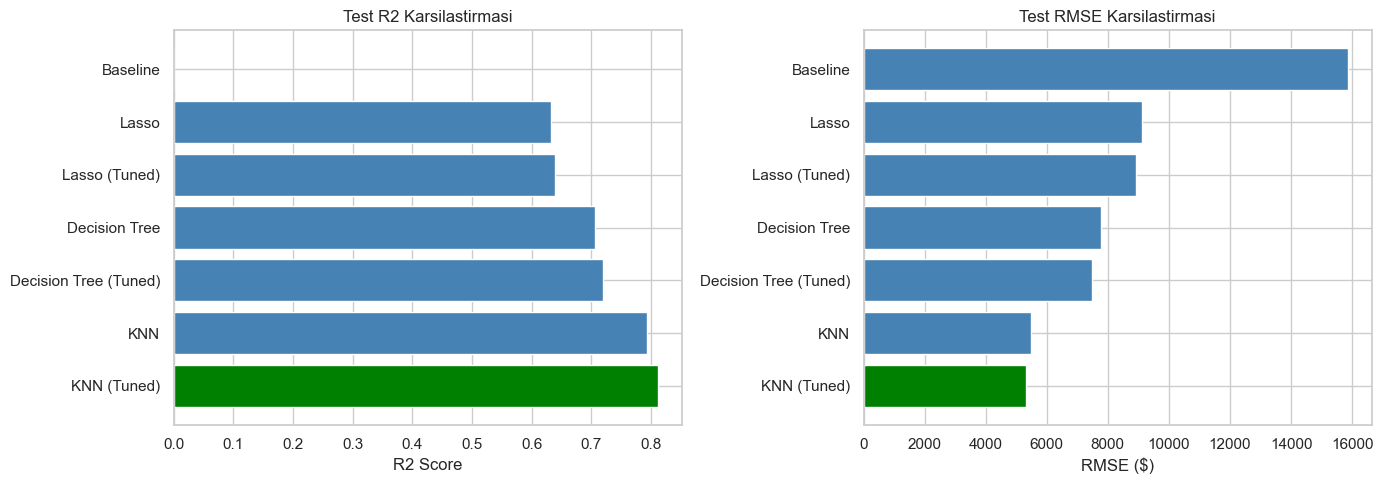

In [28]:
# Gorsellesltirme
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = comparison_df['Model'].values
r2_vals = comparison_df['Test R2'].values
colors = ['green' if m == best_model_name else 'steelblue' for m in models]

axes[0].barh(models, r2_vals, color=colors)
axes[0].set_xlabel('R2 Score')
axes[0].set_title('Test R2 Karsilastirmasi')

rmse_vals = comparison_df['Test RMSE ($)'].values
axes[1].barh(models, rmse_vals, color=colors)
axes[1].set_xlabel('RMSE ($)')
axes[1].set_title('Test RMSE Karsilastirmasi')

plt.tight_layout()
plt.show()


## 11. Validation Protokolu


In [29]:
# Cross-Validation (En iyi model icin)
print('='*60)
print('CROSS-VALIDATION (5-Fold)')
print('='*60)
best_pipeline = results[best_model_name]['pipeline']
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=kfold, scoring='r2', n_jobs=-1)
print(f'Model: {best_model_name}')
print(f'5-Fold CV R2: {cv_scores.round(4)}')
print(f'Ortalama R2: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})')


CROSS-VALIDATION (5-Fold)
Model: KNN (Tuned)
5-Fold CV R2: [0.8011 0.8021 0.8046 0.807  0.7935]
Ortalama R2: 0.8017 (+/- 0.0045)


## 12. Hata Analizi (Residual Analysis)


HATA ANALIZI


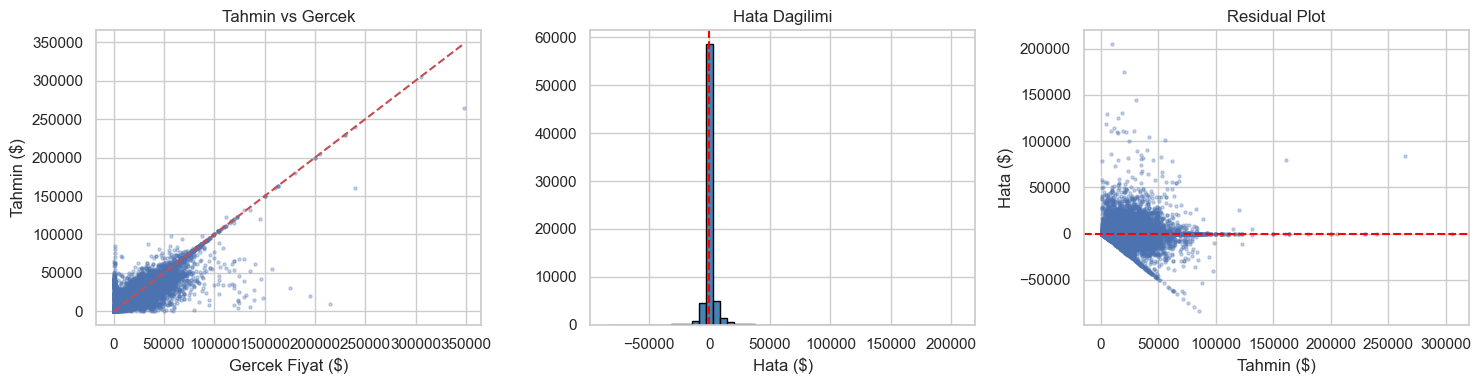

Ortalama Hata: $259
Std Hata: $5,305


In [30]:
# Hata Analizi
print('='*60)
print('HATA ANALIZI')
print('='*60)

y_pred_best = best_pipeline.predict(X_test)
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_best)
residuals = y_test_real - y_pred_real

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1) Tahmin vs Gercek
axes[0].scatter(y_test_real, y_pred_real, alpha=0.3, s=5)
axes[0].plot([0, y_test_real.max()], [0, y_test_real.max()], 'r--')
axes[0].set_xlabel('Gercek Fiyat ($)')
axes[0].set_ylabel('Tahmin ($)')
axes[0].set_title('Tahmin vs Gercek')

# 2) Hata Dagilimi
axes[1].hist(residuals, bins=50, color='steelblue', edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_xlabel('Hata ($)')
axes[1].set_title('Hata Dagilimi')

# 3) Residual Plot
axes[2].scatter(y_pred_real, residuals, alpha=0.3, s=5)
axes[2].axhline(0, color='red', linestyle='--')
axes[2].set_xlabel('Tahmin ($)')
axes[2].set_ylabel('Hata ($)')
axes[2].set_title('Residual Plot')

plt.tight_layout()
plt.show()

print(f'Ortalama Hata: ${residuals.mean():,.0f}')
print(f'Std Hata: ${residuals.std():,.0f}')


In [31]:
# Model Kaydetme
import joblib
joblib.dump({'pipeline': best_pipeline, 'model_name': best_model_name, 'r2': best_r2, 'rmse': best_rmse}, 'best_model_simplified.pkl')
print('Model kaydedildi: best_model_simplified.pkl')


Model kaydedildi: best_model_simplified.pkl


## PROJE OZETI

### Veri Madenciligi Adimlari:
1. Veri Yukleme
2. Keşifsel Veri Analizi (EDA)
3. Veri Temizleme
4. Feature Selection
5. Feature Engineering
6. Train/Test Split
7. Model Egitimi (Decision Tree, KNN, Lasso)
8. Hyperparameter Tuning
9. PCA Deneyi
10. Model Karsilastirmasi
11. Validation (Cross-Validation)
12. Hata Analizi

### Encoding Stratejisi:
- Decision Tree ve KNN: Label Encoding (hizli)
- Lasso: OneHot Encoding (linear model)

### Sonuc:
En iyi model ve performans metrikleri yukarida gosterilmistir.


## 11. Validation Protokolu

**Train/Test Bolunmesi:** %80 Train, %20 Test, random_state=42

**Cross-Validation:** Hyperparameter tuning'de 3-fold CV kullanildi
